# Caderno 9 - Calcula métricas para pesquisa em banco vetorial

In [1]:
PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/9_calcula_metricas/'
PASTA_RESULTADO_BUSCA = f'{PASTA_DADOS}outputs/8_armazena_dados_em_banco_vetorial/'

## 1. Carrega dados de jurisprudência

In [27]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

## 2. Carrega resultados da busca em banco vetorial

Carrega a lista dos resultados das queries realizadas no banco vetorial.

In [6]:
import pickle

with open(caminho_arquivo, 'rb') as arquivo:
    I = pickle.load(arquivo)
I.shape

(150, 50)

## 3. Constroi dataframe de resultados no formato esperado pela função de métricas


In [37]:
import pandas as pd

# Função para encontrar a correspondência entre keys
def find_key(doc_key, docs):
    matches = docs[docs['KEY'].str.contains(doc_key, na=False)]
    if not matches.empty:
        return matches.iloc[0]['KEY']
    return doc_key

# Criando listas para as colunas do DataFrame
col_resultado_query_key = []
col_resultado_doc_key = []
col_resultado_rank = []

# Preenchendo as listas
for query_idx in range(len(I)):
    for rank_idx in range(len(I[0])):
        col_resultado_query_key.append(query_idx+1)
        col_resultado_doc_key.append(I[query_idx, rank_idx])
        col_resultado_rank.append(rank_idx+1)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

df_resultados['DOC_KEY'] = df_resultados['DOC_KEY'].astype(str)
df_resultados['DOC_KEY'] = df_resultados['DOC_KEY'].apply(lambda x: find_key(x, docs))

In [56]:
df_resultados

,QUERY_KEY,DOC_KEY,RANK
0,1,JURISPRUDENCIA-SELECIONADA-34233,1
1,1,JURISPRUDENCIA-SELECIONADA-20870,2
2,1,JURISPRUDENCIA-SELECIONADA-18324,3
3,1,JURISPRUDENCIA-SELECIONADA-34126,4
4,1,JURISPRUDENCIA-SELECIONADA-20969,5
...,...,...,...
7495,150,JURISPRUDENCIA-SELECIONADA-23270,46
7496,150,JURISPRUDENCIA-SELECIONADA-20844,47
7497,150,JURISPRUDENCIA-SELECIONADA-16274,48
7498,150,JURISPRUDENCIA-SELECIONADA-25427,49


In [47]:
queries

,KEY,TEXT,SOURCE
0,1,técnica e preço,search log
1,2,restos a pagar,search log
2,3,aditivo a contrato,search log
3,4,adesão a ata de registro de preços,search log
4,5,sobrepreço e superfaturamento,search log
...,...,...,...
145,146,É possível a inclusão de serviços já previstos...,LLM
146,147,O princípio da legalidade estrita pode ser afa...,LLM
147,148,Quais fontes devem ser prioritárias na pesquis...,LLM
148,149,Devem ser aceitas nas contratações de software...,LLM


## 3. Calcula métricas

In [42]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.128000,0.108000,0.080000,0.053200,0.052322,0.088039,0.129010,0.214094,0.269000,0.287746,0.297197,0.300719,0.131622,0.121379,0.137600,0.179774
std,14.57738,0.179614,0.136785,0.082065,0.041524,0.075721,0.118290,0.140250,0.178199,0.382022,0.371397,0.364655,0.361888,0.193388,0.148412,0.155047,0.173737
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.25000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.040870,0.000000,0.000000,0.000000,0.028665
50%,25.50000,0.000000,0.100000,0.050000,0.050000,0.000000,0.071429,0.087121,0.190909,0.000000,0.125000,0.125000,0.125000,0.000000,0.068786,0.074561,0.141711
75%,37.75000,0.200000,0.175000,0.100000,0.080000,0.081731,0.122727,0.163462,0.326923,0.458333,0.458333,0.458333,0.458333,0.213986,0.220963,0.218206,0.293876
max,50.00000,0.600000,0.600000,0.300000,0.140000,0.300000,0.545455,0.545455,0.600000,1.000000,1.000000,1.000000,1.000000,0.654809,0.477299,0.539103,0.583610


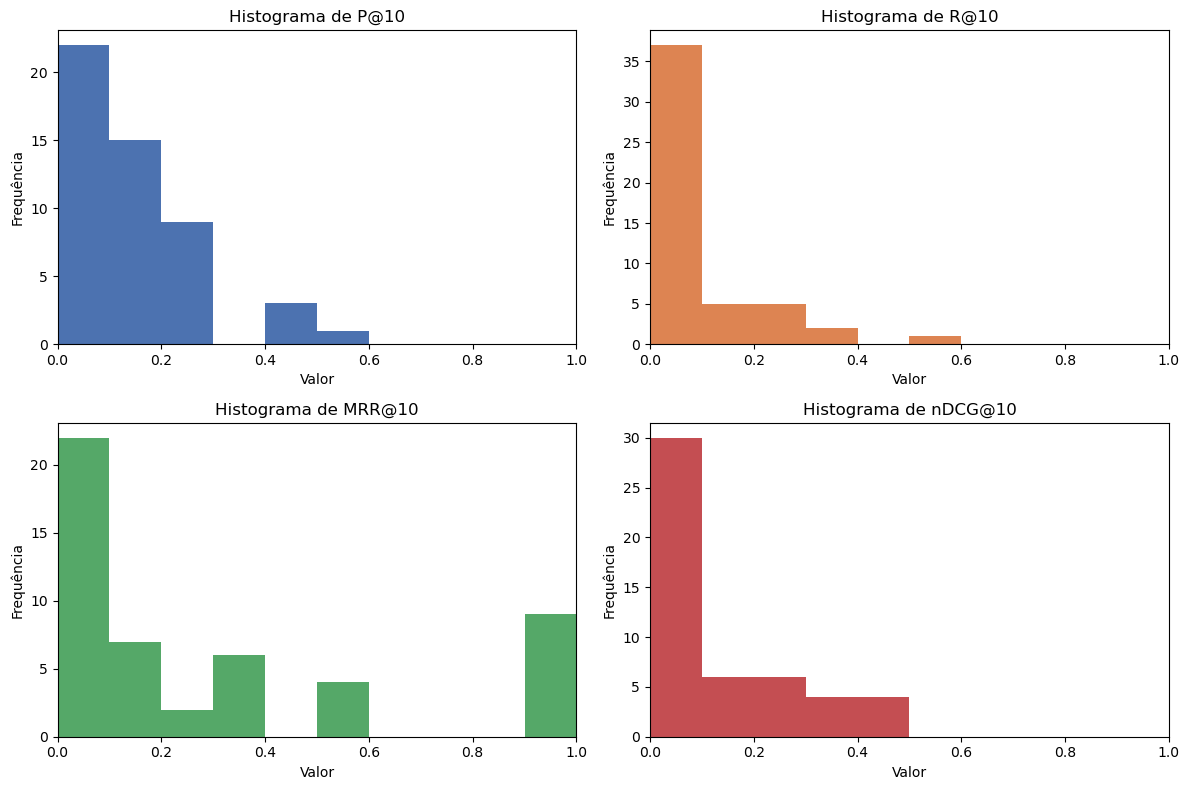

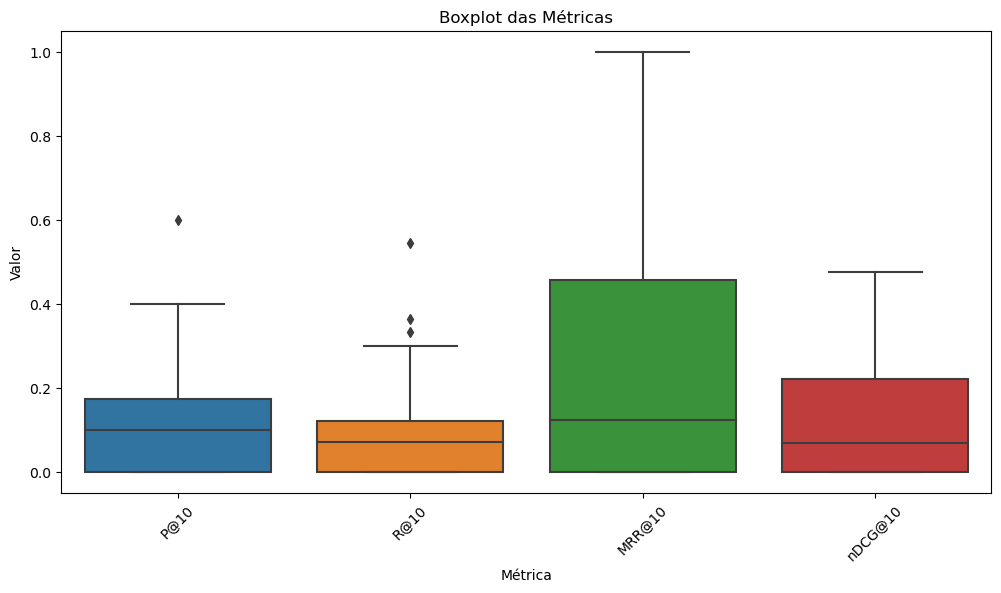

In [43]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.224000,0.166000,0.119000,0.070400,0.092488,0.137179,0.195604,0.289902,0.449667,0.463714,0.468918,0.471608,0.234739,0.209887,0.234424,0.278223
std,14.57738,0.219981,0.147924,0.091412,0.045399,0.093326,0.127432,0.155372,0.197293,0.430992,0.417970,0.412448,0.409431,0.245961,0.200027,0.197131,0.200828
min,51.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.25000,0.000000,0.025000,0.050000,0.040000,0.000000,0.016667,0.078526,0.153846,0.000000,0.031250,0.099432,0.099432,0.000000,0.009028,0.078337,0.124602
50%,75.50000,0.200000,0.150000,0.100000,0.060000,0.076923,0.121429,0.166667,0.258333,0.333333,0.333333,0.333333,0.333333,0.182093,0.168459,0.198551,0.265653
75%,87.75000,0.400000,0.200000,0.150000,0.100000,0.163462,0.181818,0.287500,0.416667,1.000000,1.000000,1.000000,1.000000,0.431196,0.386191,0.371473,0.393952
max,100.00000,0.800000,0.600000,0.350000,0.180000,0.363636,0.545455,0.636364,0.818182,1.000000,1.000000,1.000000,1.000000,0.868795,0.738557,0.762528,0.832129


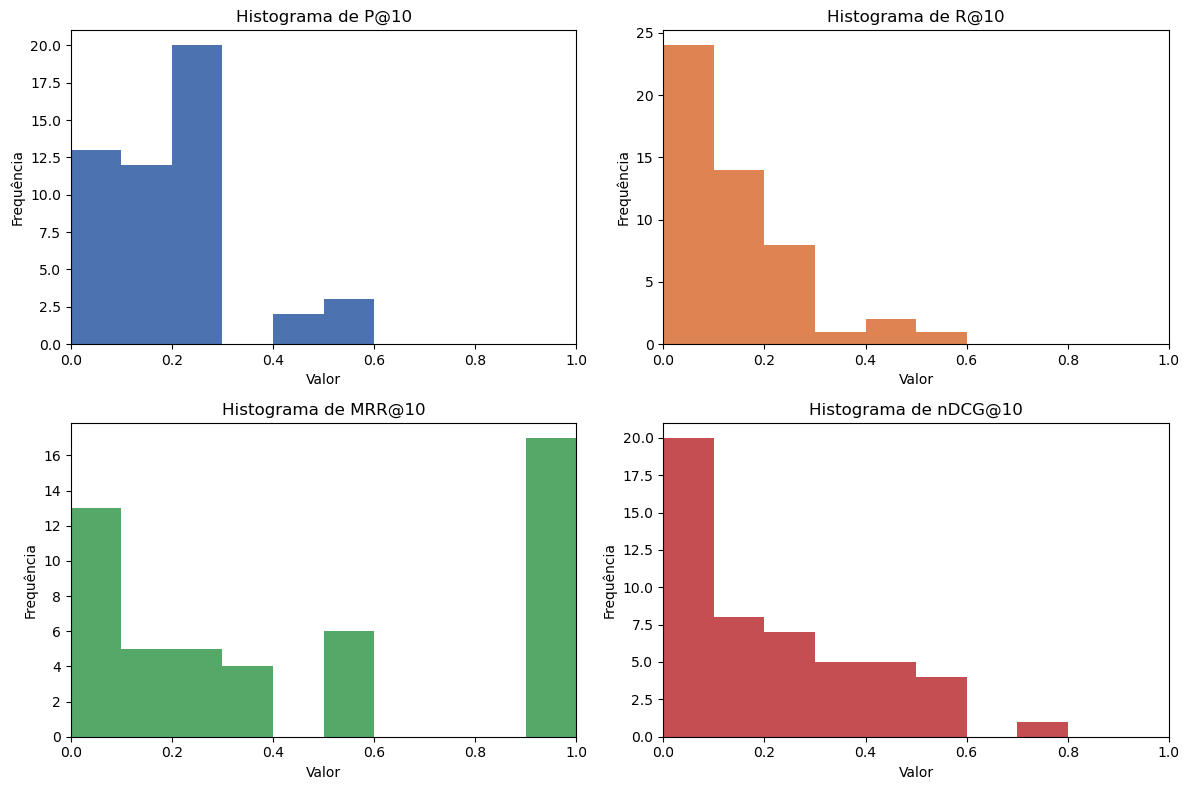

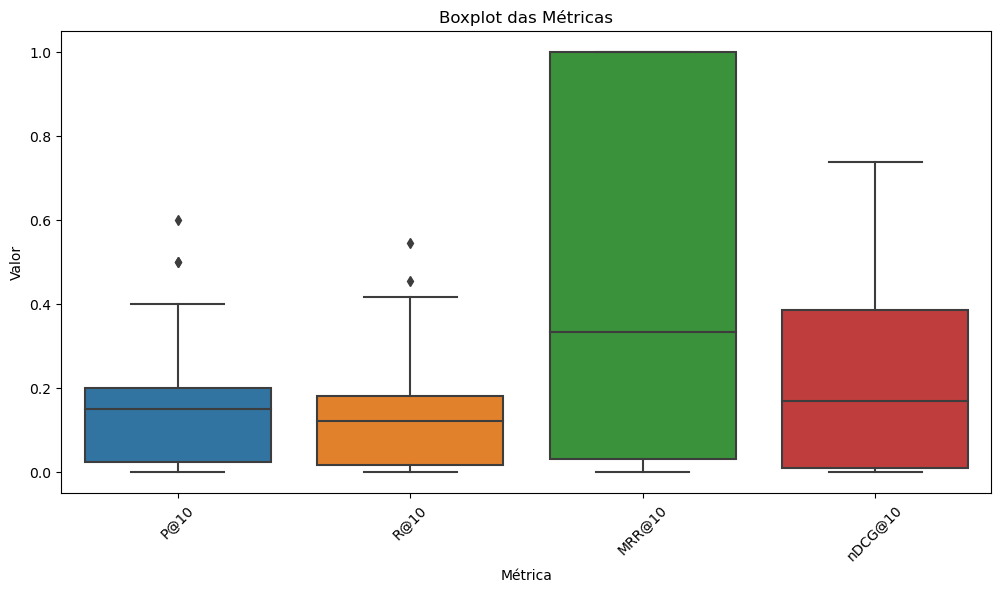

In [54]:
# Resultados para o segundo grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.236000,0.182000,0.136000,0.073200,0.106031,0.161149,0.240637,0.323122,0.472333,0.492103,0.501194,0.501884,0.259939,0.233840,0.274202,0.309866
std,14.57738,0.231023,0.139518,0.095319,0.044006,0.103611,0.124717,0.167608,0.194011,0.430625,0.410566,0.400242,0.399390,0.251003,0.186182,0.189120,0.199376
min,101.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,113.25000,0.000000,0.100000,0.050000,0.040000,0.000000,0.076923,0.100000,0.186364,0.000000,0.114583,0.114583,0.114583,0.000000,0.073628,0.115552,0.159980
50%,125.50000,0.200000,0.200000,0.100000,0.080000,0.087121,0.166667,0.215385,0.320513,0.333333,0.333333,0.333333,0.333333,0.218761,0.228253,0.263667,0.296666
75%,137.75000,0.400000,0.300000,0.200000,0.095000,0.166667,0.245192,0.333333,0.412500,1.000000,1.000000,1.000000,1.000000,0.457332,0.365476,0.389804,0.428962
max,150.00000,0.800000,0.600000,0.400000,0.180000,0.363636,0.545455,0.727273,0.818182,1.000000,1.000000,1.000000,1.000000,0.868795,0.667220,0.766775,0.766775


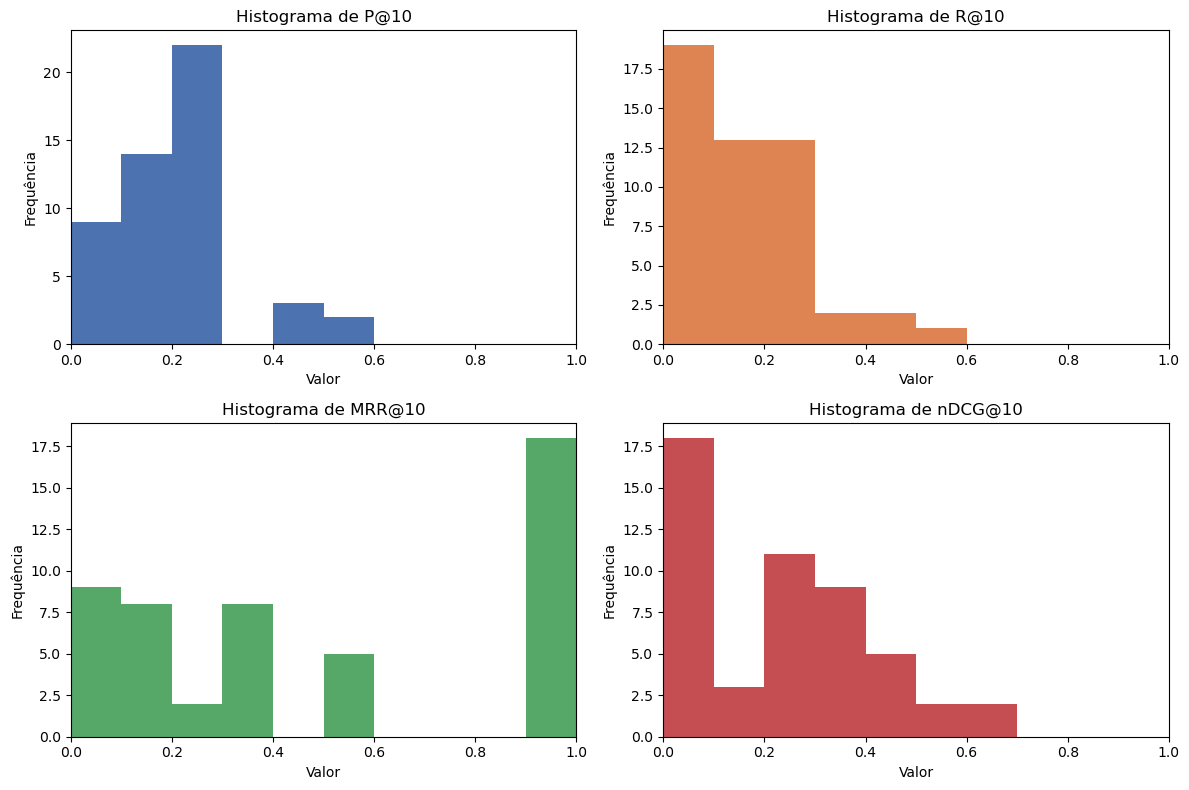

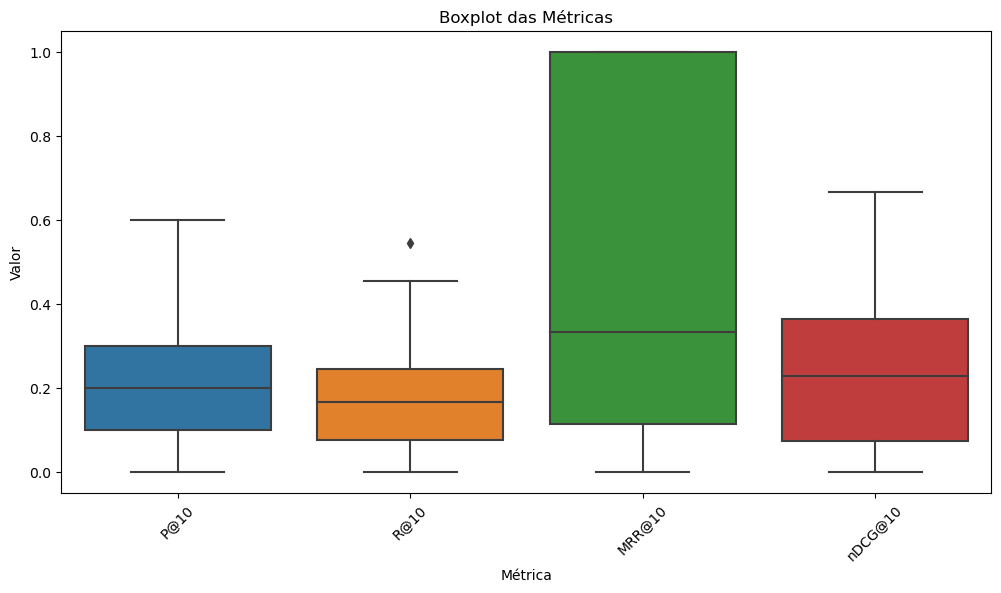

In [55]:
# Resultados para o terceiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])